# EEG Wheelchair Binary Classification ML Model
## Using 1D Convolutional Networks and Recurrent Networks
This is the first experiment with trying to convert 4 channel EEG brain wave data into a binary classification of stop and go for the EEG wheelchair control system.

## Overview
The following notebook will follow these next steps:
1. Data Cleaning
    - Get rid of inconsistent samples or bad samples
2. Data Preprocessing
    - Convert to wavelet transforms and take signal squeezed signals
3. Data Filtering
    - Filter out irrelevant frequencies and disconnections
4. Build Model
    - Form CNN-RNN network for prediction modelling
5. Model Training
    - Train model on training set of EEG Samples
6. Hyperparameter Optimization
    - Optimize model hyperparameters by cross validation 
7. Model Validation
    - Validate model on test set


# Trial 2
## Summary
1. Seperate training and testing samples before cutting and shuffling
    - We made the mistake first time round to split the training and test data after
      cut and shuffle the data.
    - This means that each sample has been re-shuffled into the training and test data
    - This made predicitons way easier, because all of what was tested was already in
      the training data
      
2. Try model fine tuning
    - Because the model is bad at adapting to different people and positions
    - Try tuning the model slightly before every sitting or person change


In [1]:
# Basic imports
from datetime import datetime
import numpy as np
import glob
import os
import sys
from collections import defaultdict
from sklearn.utils import shuffle
import random

# Data management
import pandas as pd

# Data processing
from ssqueezepy import ssq_cwt

# Model training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow as tf
import matplotlib.pyplot as plt

## Try test file

In [ ]:
# Read test EEG data from dat directory
test_file = pd.read_csv('./datasets/individual_dataset/GO/dk_1673902242.csv', header=None)
test_file

In [ ]:
# Try test file

# Convert to numpy arrays
timestamps, tp9, af7, af8, tp10 = test_file.T.to_numpy()

# Get the frequency of the samples 
start = datetime.strptime(str(timestamps[0]), "%Y-%m-%d %H:%M:%S.%f")
end = datetime.strptime(str(timestamps[-1]), "%Y-%m-%d %H:%M:%S.%f")
duration = (end-start).total_seconds()
fs = timestamps.size/duration

Twtp9, Wtp9, *_ = ssq_cwt(tp9, fs=fs)
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(3, 1, 2)
plt.imshow(np.abs(Twtp9), aspect='auto', cmap='turbo')
fig.add_subplot(3, 1, 1)
plt.imshow(np.abs(Wtp9), aspect='auto', cmap='turbo')
plt.show()


## Importing Data

In [3]:
# Pull all training files data

# ENTER FILE EXTS HERE
data_path = './datasets/individual_dataset/'
train_name = 'dk1'
test_name = 'dk1_test'
val_name = 'dk'

train_files = defaultdict(list)
test_files = defaultdict(list)
val_files = defaultdict(list)
file_types = ("GO", "REST", "STOP")

num_train_files = 1000
#num_test_files = 1000
num_val_files = 1000

# Get even amounts of all files
for file_type in file_types:
    fileglob = os.path.join(data_path, file_type, '%s_1*.csv' % train_name)
    num_train_files = min(num_train_files, len(glob.glob(fileglob)))
    fileglob = os.path.join(data_path, file_type, '%s_1*.csv' % test_name)
    #num_test_files = min(num_test_files, len(glob.glob(fileglob)))
    fileglob = os.path.join(data_path, file_type, '%s_1*.csv' % val_name)
    num_val_files = min(num_val_files, len(glob.glob(fileglob)))
    
for file_type in file_types:
    fileglob = os.path.join(data_path, file_type, '%s_1*.csv' % train_name)
    
    for i, file in enumerate(shuffle(glob.glob(fileglob))):
        if i == num_train_files:
            break
        train_files[file_type].append(pd.read_csv(file, header=None))

    print(len(train_files[file_type]))
    
    fileglob = os.path.join(data_path, file_type, '%s_1*.csv' % test_name)
    
    for i, file in enumerate(shuffle(glob.glob(fileglob))):
        #if i == num_test_files:
        #    break
        test_files[file_type].append(pd.read_csv(file, header=None))

    print(len(test_files[file_type]))
    
    fileglob = os.path.join(data_path, file_type, '%s_1*.csv' % val_name)
    
    for i, file in enumerate(shuffle(glob.glob(fileglob))):
        if i == num_val_files:
            break
        val_files[file_type].append(pd.read_csv(file, header=None))

    print(len(val_files[file_type]))

33
6
9
33
9
9
33
2
9


## Convert to wavelet transform signal squeezed

In [4]:
def ts_to_ssq(timeseries):
    """
    Converts 4 channel time series data to ssq wavelet transform
    """
    timestamps, tp9, af7, af8, tp10 = timeseries
    
    # Get the frequency of the samples 
    start = datetime.strptime(str(timestamps[0]), "%Y-%m-%d %H:%M:%S.%f")
    end = datetime.strptime(str(timestamps[-1]), "%Y-%m-%d %H:%M:%S.%f")
    duration = (end-start).total_seconds()
    fs = timestamps.size/duration
    
    Twtp9, _, *_ = ssq_cwt(tp9, fs=fs)
    Twtp10, _, *_ = ssq_cwt(tp10, fs=fs)
    Twaf7, _, *_ = ssq_cwt(af7, fs=fs)
    Twaf8, _, *_ = ssq_cwt(af8, fs=fs)
    
    return np.array((Twtp9, Twaf7, Twaf8, Twtp10))

In [25]:
original_sample_size = 3000
buffer_sample_size = 500
training_sample_size = 25

key_dict = {"STOP":(0.0, 0.0, 1.0),
            "GO":(0.0, 1.0, 0.0),
            "REST": (1.0, 0.0, 0.0)}

def compile_files(files, file_type):
    X = []
    t = []
    
    num_files = sum([len(x) for x in files.values()])
    
    for key, data in files.items():
        for recording in data:
            # if file is smaller than 3000 samples, don't use it
            if len(recording[0]) < original_sample_size:
                continue

            # Split file into buffer size samples
            time_samples = np.split(recording.head(original_sample_size).T.to_numpy(),
                                         int(original_sample_size/buffer_sample_size), axis=1)

            for time_sample in time_samples:
                # Convert to numpy arrays
                ssq_data = ts_to_ssq(time_sample)

                # Take the magnitude of the wavelet transform only
                ssq_data = np.abs(ssq_data)

                # Must transpose data to (frame, height, channel) for training
                ssq_data = ssq_data.transpose(2,1,0)

                # Split sample into many blocks
                wavelet_samples = np.split(ssq_data, int(buffer_sample_size/training_sample_size))

                X.extend(wavelet_samples)
                t.extend([key_dict[key] for i in range(len(wavelet_samples))])
                
            
            print("%d %s files left to convert " % (num_files, file_type), end="\r")
            num_files -= 1
                
    return np.array(X), np.array(t)

In [26]:
# Compile all files into train data
X_train, t_train = compile_files(train_files, 'train')

X_test, t_test = compile_files(test_files, 'val')

X_val, t_val = compile_files(val_files, 'test')

In [27]:
print("Training data")
print(X_train.shape)
print(t_train.shape)
print("Testing data")
print(X_test.shape)
print(t_test.shape)
print("Validation data")
print(X_val.shape)
print(t_val.shape)

Training data
(11760, 25, 229, 4)
(11760, 3)
Testing data
(2040, 25, 229, 4)
(2040, 3)
Validation data
(3120, 25, 229, 4)
(3120, 3)


In [ ]:
# Save the ssq data
if os.path.isdir('processed_data'):
    os.remove('processed_data/examples.npy')
    os.remove('processed_data/targets.npy')
else:
    os.mkdir('processed_data')
np.save('processed_data/examples.npy', X)
np.save('processed_data/targets.npy', t)

## *Shortcut: Load Preprocessed Saved Data*

In [ ]:
# Load ssq data
X = np.load('processed_data/examples.npy')
t = np.load('processed_data/targets.npy')

## Shuffle data

In [28]:
# Shuffle the data
X_train, t_train = shuffle(X_train, t_train)
X_test, t_test = shuffle(X_test, t_test)
X_val, t_val = shuffle(X_val, t_val)



In [29]:
X_train.shape

(11760, 25, 229, 4)

In [31]:
t_train.shape

(11760, 3)

## Train Model

## 1st attempt
- Unique Validation split
- batch size : 5
- epochs : 15
- 4 channel input -> 4 to 1 channel time distributed CNN -> GRU RNN -> Dense layers (leaky relu) -> Dense Layers (softmax)
- loss function = categorical cross entropy
- 500 frame samples before running ssq

### Changes made
- Using different files for validation and testing than training
- Same person's data

### Expected results
- Hopefully some correlation between training accuracy and val accuracy
- Probably need more training data
- Might need smaller sample size for more training data

### Issues noticed
    


In [32]:
# Declare a sequential model
model = Sequential()

# Declare input shape of
model.add(Input(shape=X_train[0].shape)) # shape = frames, height, channels

# First add Convolution and Pooling layers
model.add(TimeDistributed(Conv1D(253, (3))))
model.add(TimeDistributed(Activation('relu')))

model.add(TimeDistributed(Conv1D(253, (2))))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=(2))))

# Flatten to prepare for Recurrent network
model.add(TimeDistributed(Flatten()))

# Recurrent layers connect to each of the time steps
model.add(GRU(128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu')
         )
model.add(Dropout(0.4))
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.4))

# Output is 3, REST, GO, STOP likelihood
model.add(Dense(3, activation='softmax'))

2023-02-02 21:55:40.867122: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-02-02 21:55:40.944959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: Tesla K20Xm computeCapability: 3.5
coreClock: 0.732GHz coreCount: 14 deviceMemorySize: 5.57GiB deviceMemoryBandwidth: 232.46GiB/s
2023-02-02 21:55:40.945439: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-02 21:55:40.949202: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-02 21:55:40.952372: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-02-02 21:55:40.953061: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-

In [33]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 25, 227, 253)      3289      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 25, 227, 253)      0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 25, 226, 253)      128271    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 25, 226, 253)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 25, 113, 253)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 25, 28589)         0         
_________________________________________________________________
gru (GRU)                    (None, 128)               1

In [ ]:
model.get_weights()

In [35]:
stdout = sys.stdout
f = open("results/trial2/attempt1.txt", 'w')
sys.stdout = f
results = model.fit(X_train, t_train, validation_data=(X_val, t_val), batch_size=5, epochs=15)
sys.stdout = stdout
f.close()

2023-02-02 21:57:51.768965: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-02 21:57:51.929285: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


In [36]:
test_results = model.evaluate(X_test, t_test)

64/64 [==============================] - 6s 99ms/step - loss: 2.9841 - accuracy: 0.5858


In [40]:
model.predict(X_test[100:110])

array([[1.0000000e+00, 1.5646729e-09, 1.0208837e-10],
       [1.9230423e-05, 9.9937409e-01, 6.0670241e-04],
       [2.8931150e-02, 7.6966459e-01, 2.0140427e-01],
       [3.1096356e-02, 2.1779172e-01, 7.5111192e-01],
       [1.6252114e-05, 9.9872953e-01, 1.2541785e-03],
       [9.9632572e-03, 8.9626610e-02, 9.0041012e-01],
       [1.0699883e-02, 7.3641814e-02, 9.1565835e-01],
       [5.8063496e-02, 3.4277478e-01, 5.9916174e-01],
       [9.9999964e-01, 3.5829615e-07, 2.6361855e-08],
       [9.8202378e-04, 9.9126059e-01, 7.7574286e-03]], dtype=float32)

In [39]:
t_test[100:110]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [41]:
# To save the model
model.save('models/trial2/attempt1_500.h5')

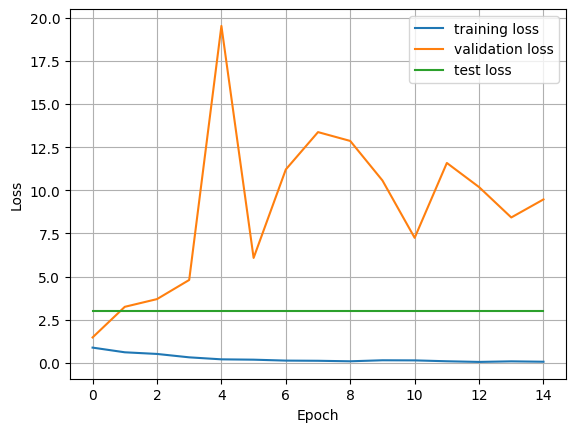

In [42]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.plot([test_results[0] for i in range(len(results.history['loss']))])
plt.legend(('training loss', 'validation loss', 'test loss'))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.savefig('results/trial2/attempt1_loss.png')

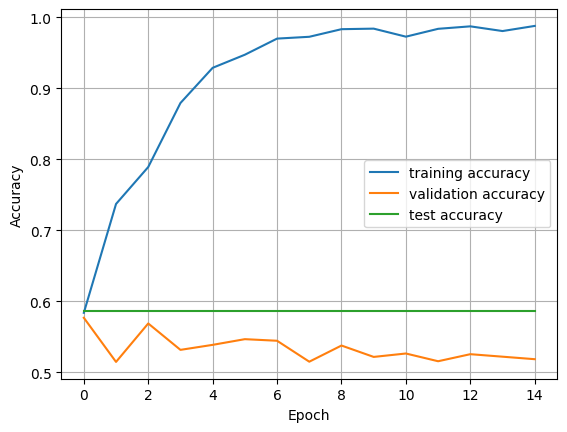

In [43]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.plot([test_results[1] for i in range(len(results.history['accuracy']))])
plt.legend(('training accuracy', 'validation accuracy', 'test accuracy'))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.savefig('results/trial2/attempt1_accuracy.png')

## 2nd attempt
- Unique Validation split
- batch size : 5
- epochs : 30
- 4 channel input -> 4 to 1 channel time distributed CNN -> GRU RNN -> Dense layers (leaky relu) -> Dense Layers (softmax)
- loss function = categorical cross entropy
- 500 frame samples before running ssq

### Changes made
- Try with more data, reduced sample size to create more data
- Do more recordings of my own data, with taking off the headset halfway through

### Expected results

### Issues noticed
    
